In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [4]:
cali = fetch_california_housing()
cali_df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
cali_df['Target'] = cali['target']
cali_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
data = torch.from_numpy(cali_df.values).float()
data.shape

torch.Size([20640, 9])

In [6]:
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640, 1]))

In [7]:
scaler = StandardScaler().fit(X)
X_sc = torch.from_numpy(scaler.transform(X).round(4)).float()
X_sc

tensor([[ 2.3448,  0.9821,  0.6286,  ..., -0.0496,  1.0525, -1.3278],
        [ 2.3322, -0.6070,  0.3270,  ..., -0.0925,  1.0432, -1.3228],
        [ 1.7827,  1.8562,  1.1556,  ..., -0.0258,  1.0385, -1.3328],
        ...,
        [-1.1426, -0.9249, -0.0903,  ..., -0.0717,  1.7782, -0.8237],
        [-1.0546, -0.8454, -0.0402,  ..., -0.0912,  1.7782, -0.8736],
        [-0.7801, -1.0043, -0.0704,  ..., -0.0437,  1.7501, -0.8337]])

In [8]:
n_epochs = 10000
print_interval = 1000

In [9]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__()

        self.linear1 = nn.Linear(input_dim, 7)
        self.linear2 = nn.Linear(7, 5)
        self.linear3 = nn.Linear(5, 3)
        self.linear4 = nn.Linear(3, output_dim)
        self.act = nn.LeakyReLU()

    def forward(self, X):
        h = self.act(self.linear1(X))
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        y = self.linear4(h)
        return y

In [11]:
#model = MyModel(X.shape[-1], y.shape[-1])
#optimizer = optim.Adam(model.parameters())

In [12]:
model = nn.Sequential(
    nn.Linear(X_sc.shape[-1], 7),
    nn.LeakyReLU(),
    nn.Linear(7, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.shape[-1])
)
optimizer = optim.Adam(model.parameters())

In [13]:
for i in range(n_epochs):
    y_hat = model(X_sc)
    loss = F.mse_loss(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: loss={loss}')

Epoch 1000: loss=0.393150269985199
Epoch 2000: loss=0.35854190587997437
Epoch 3000: loss=0.3499951660633087
Epoch 4000: loss=0.3436456024646759
Epoch 5000: loss=0.34024375677108765
Epoch 6000: loss=0.3376747667789459
Epoch 7000: loss=0.33449867367744446
Epoch 8000: loss=0.3337533473968506
Epoch 9000: loss=0.3332674205303192
Epoch 10000: loss=0.33302703499794006


In [14]:
result_df = pd.DataFrame(torch.concat([y, y_hat], dim=1).detach_().numpy(), columns=['y', 'y_hat']).clip(lower=0, upper=5)
result_df

,y,y_hat
0,4.526,4.217575
1,3.585,4.658097
2,3.521,4.390451
3,3.413,3.637709
4,3.422,3.077282
...,...,...
20635,0.781,0.748353
20636,0.771,0.833918
20637,0.923,0.901101
20638,0.847,0.943302


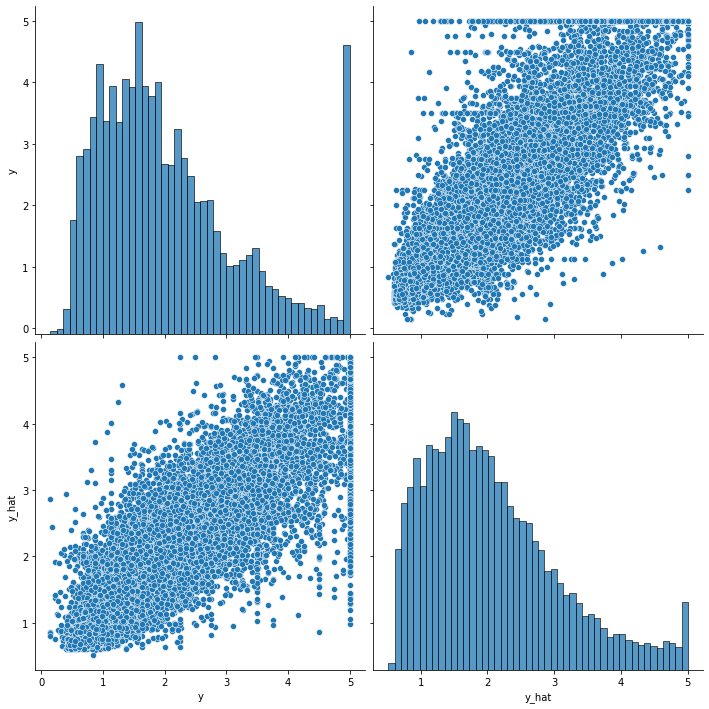

In [15]:
sns.pairplot(result_df, height=5)
plt.show()